In [1]:
# 安裝必要的庫 (如果尚未安裝，請解除註解下方命令)
# !pip install numpy pandas matplotlib scikit-learn keras tensorflow
# !pip install pandas_datareader yfinance
# !pip install --upgrade keras tensorflow

import warnings

# 禁用所有警告
warnings.filterwarnings("ignore")

In [6]:
import datetime
import yfinance as yf

stock_number = '0050.TW'
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2024, 1, 16)

df = yf.download(stock_number, start=start, end=end)
print(df.head())  # Print the first few rows of the DataFrame
print(f"DataFrame shape: {df.shape}")  # Check the shape of the DataFrame

if df.empty:
    raise ValueError("DataFrame is empty. Please check the stock symbol or date range.")


[*********************100%***********************]  1 of 1 completed

Price                      Adj Close      Close       High        Low  \
Ticker                       0050.TW    0050.TW    0050.TW    0050.TW   
Date                                                                    
2008-01-02 00:00:00+00:00  42.407536  60.009998  60.009998  60.009998   
2008-01-03 00:00:00+00:00  41.616070  58.889999  58.889999  58.889999   
2008-01-04 00:00:00+00:00  41.700867  59.009998  59.009998  59.009998   
2008-01-07 00:00:00+00:00  39.849380  56.389999  56.389999  56.389999   
2008-01-08 00:00:00+00:00  40.266319  56.980000  56.980000  56.980000   

Price                           Open  Volume  
Ticker                       0050.TW 0050.TW  
Date                                          
2008-01-02 00:00:00+00:00  60.009998       0  
2008-01-03 00:00:00+00:00  58.889999       0  
2008-01-04 00:00:00+00:00  59.009998       0  
2008-01-07 00:00:00+00:00  56.389999       0  
2008-01-08 00:00:00+00:00  56.980000       0  
DataFrame shape: (3942, 6)


In [8]:
from sklearn.preprocessing import StandardScaler
from collections import deque
import numpy as np

def Stock_Price_LSTM_Data_Preprocessing(df, mem_his_days, pre_days):
    # 複製原始 DataFrame，以確保原始數據不會被修改
    df = df.copy()
    print('Initial DataFrame shape:', df.shape)
    
    # 刪除缺失值
    df.dropna(inplace=True)
    print('Shape after dropping NAs:', df.shape)

    # 確保有足夠的數據來生成標籤
    if df.shape[0] <= mem_his_days + pre_days:
        print('Not enough data after preprocessing.')
        return None, None, None  # 返回 None 以表示無效數據

    df['label'] = df['Close'].shift(-pre_days)
    df.dropna(inplace=True)  # 刪除因標籤生成而產生的NaN值
    print('Shape after dropping NAs from label:', df.shape)

    # 檢查是否有有效的數據進行標準化
    if df.shape[0] == 0:
        print('DataFrame is empty after dropping NaNs.')
        return None, None, None  # 返回 None 以表示無效數據

    try:
        scaler = StandardScaler()
        sca_X = scaler.fit_transform(df.iloc[:, :-1])  # 對特徵進行標準化
        print('Data after StandardScaler, shape:', sca_X.shape)
    except ValueError as e:
        print('Error during standardization:', e)
        return None, None, None  # 返回 None 以表示無效數據

    deq = deque(maxlen=mem_his_days)
    X = []
    
    for i in sca_X:
        deq.append(list(i))
        if len(deq) == mem_his_days:
            X.append(list(deq))

    X_lately = X[-pre_days:]
    X = X[:-pre_days]

    y = df['label'].values[mem_his_days-1:-pre_days]
    
    print('Final X, y shapes:', np.array(X).shape, np.array(y).shape)

    X = np.array(X)
    y = np.array(y)

    return X, y, X_lately

In [9]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# 設置混合精度策略
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import optuna
import numpy as np

# 配置 GPU 設置
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 定義目標函數以供 Optuna 優化
def objective(trial):
    # 超參數範圍設定
    the_pre_days = trial.suggest_categorical('pre_days', [5, 10, 15, 20, 25, 30])
    the_mem_days = trial.suggest_categorical('mem_days', [5, 10, 15, 20, 25, 30])
    the_lstm_layers = trial.suggest_int('lstm_layers', 1, 5)
    the_dense_layers = trial.suggest_int('dense_layers', 1, 5)
    the_units = trial.suggest_categorical('units', [16, 32, 64])

    # 數據預處理
    X, y, X_lately = Stock_Price_LSTM_Data_Preprocessing(df, the_mem_days, the_pre_days)
    
    # 檢查數據是否有效
    if X.shape[0] == 0 or y.shape[0] == 0:
        return float("inf")  # 返回一個很大的值以標記失敗

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

    # 建立模型
    model = Sequential()
    model.add(LSTM(the_units, input_shape=X.shape[1:], return_sequences=True))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    for _ in range(the_lstm_layers - 1):
        model.add(LSTM(the_units, return_sequences=True))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.1))

    model.add(LSTM(the_units))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    for _ in range(the_dense_layers):
        model.add(Dense(the_units))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.1))

    model.add(Dense(1))

    # 編譯模型
    lr_schedule = ExponentialDecay(initial_learning_rate=0.00085, decay_steps=10000, decay_rate=0.95)
    optimizer = Adam(learning_rate=lr_schedule, clipnorm=1.0)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mape'])

    # 訓練模型並返回驗證指標
    try:
        history = model.fit(X_train,
                            y_train,
                            batch_size=32,
                            epochs=50,
                            validation_data=(X_test, y_test),
                            verbose=1)  # 設置為0以減少輸出

        # 檢查驗證 MAPE 是否為 NaN
        if np.isnan(min(history.history['val_mape'])):
            return float("inf")  # 返回一個很大的值以標記失敗

        # 返回驗證 MAPE 作為目標值
        return min(history.history['val_mape'])

    except Exception as e:
        print(f"An error occurred: {e}")
        return float("inf")  # 返回一個很大的值以標記失敗

# 使用 Optuna 優化超參數
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # 設置試驗次數

# 輸出最佳超參數組合
print("Best hyperparameters: ", study.best_params)

[I 2024-11-02 22:05:45,188] A new study created in memory with name: no-name-5b3612b0-c347-4d99-a59a-0457dadd06d9


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3932, 7)
Data after StandardScaler, shape: (3932, 6)
Final X, y shapes: (3898, 25, 6) (3898,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 5838.6475 - mape: 99.3872 - val_loss: 14131.1768 - val_mape: 98.6676
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 5256.8613 - mape: 97.4320 - val_loss: 12763.1113 - val_mape: 93.7280
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 4963.8022 - mape: 94.3612 - val_loss: 11468.4004 - val_mape: 88.8349
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 4435.6978 - mape: 91.2384 - val_loss: 7840.2124 - val_mape: 73.4559
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 4060.5725 - mape: 88.3630 - val_loss: 7476.7661 - val_mape: 71.6248
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 3481.4814 - mape: 83.4538 - val_loss: 4677.8647 - val_mape: 56.5039
Epoch 7/50
110/110 

[I 2024-11-02 22:09:00,202] Trial 0 finished with value: 4.309683322906494 and parameters: {'pre_days': 10, 'mem_days': 25, 'lstm_layers': 4, 'dense_layers': 2, 'units': 32}. Best is trial 0 with value: 4.309683322906494.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3932, 7)
Data after StandardScaler, shape: (3932, 6)
Final X, y shapes: (3918, 5, 6) (3918,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 5770.5747 - mape: 100.4137 - val_loss: 14374.8789 - val_mape: 99.4614
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5789.8945 - mape: 99.0957 - val_loss: 13973.1904 - val_mape: 98.0754
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5578.4209 - mape: 97.7691 - val_loss: 13085.2119 - val_mape: 94.8884
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5307.2446 - mape: 96.3206 - val_loss: 11534.5508 - val_mape: 89.1014
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4988.1309 - mape: 94.5383 - val_loss: 10372.4404 - val_mape: 84.4952
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4776.0537 - mape: 92.6609 - val_loss: 9686.9746 - val_mape: 81.6915
Epoch 7/50
111/11

[I 2024-11-02 22:10:10,877] Trial 1 finished with value: 3.624117374420166 and parameters: {'pre_days': 10, 'mem_days': 5, 'lstm_layers': 5, 'dense_layers': 2, 'units': 16}. Best is trial 1 with value: 3.624117374420166.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3917, 7)
Data after StandardScaler, shape: (3917, 6)
Final X, y shapes: (3883, 10, 6) (3883,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 5828.2485 - mape: 100.2985 - val_loss: 13964.1797 - val_mape: 98.4150
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5291.6719 - mape: 98.1448 - val_loss: 12513.7168 - val_mape: 93.1261
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4970.2598 - mape: 95.5125 - val_loss: 11267.8789 - val_mape: 88.3544
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4702.1499 - mape: 92.4879 - val_loss: 8872.3623 - val_mape: 78.3737
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4208.4580 - mape: 89.4606 - val_loss: 6878.1602 - val_mape: 68.8785
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3730.0125 - mape: 84.9801 - val_loss: 5777.8008 - val_mape: 63.0811
Epoch 7/50
110/110

[I 2024-11-02 22:11:42,462] Trial 2 finished with value: 5.308581352233887 and parameters: {'pre_days': 25, 'mem_days': 10, 'lstm_layers': 3, 'dense_layers': 1, 'units': 32}. Best is trial 1 with value: 3.624117374420166.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3927, 7)
Data after StandardScaler, shape: (3927, 6)
Final X, y shapes: (3898, 15, 6) (3898,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 5888.3853 - mape: 99.7841 - val_loss: 14098.6758 - val_mape: 98.6777
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5723.1113 - mape: 98.6953 - val_loss: 13194.3496 - val_mape: 95.4364
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5354.0771 - mape: 97.0451 - val_loss: 12102.0947 - val_mape: 91.4042
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5169.9370 - mape: 95.1997 - val_loss: 11104.0723 - val_mape: 87.5607
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4792.5034 - mape: 93.0789 - val_loss: 10140.6826 - val_mape: 83.6409
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4438.0532 - mape: 90.3987 - val_loss: 9274.5107 - val_mape: 79.9806
Epoch 7/50
110/110 ━━━━

[I 2024-11-02 22:12:33,934] Trial 3 finished with value: 4.817399978637695 and parameters: {'pre_days': 15, 'mem_days': 15, 'lstm_layers': 1, 'dense_layers': 2, 'units': 16}. Best is trial 1 with value: 3.624117374420166.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3912, 7)
Data after StandardScaler, shape: (3912, 6)
Final X, y shapes: (3868, 15, 6) (3868,)
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 5917.9097 - mape: 100.0141 - val_loss: 14254.5967 - val_mape: 99.5144
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5471.4790 - mape: 98.1049 - val_loss: 13504.9053 - val_mape: 96.8685
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5089.5884 - mape: 95.4975 - val_loss: 11428.2773 - val_mape: 89.0191
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4658.5234 - mape: 92.0519 - val_loss: 9557.6377 - val_mape: 81.3923
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4115.8501 - mape: 88.2550 - val_loss: 6667.8882 - val_mape: 67.9209
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3667.6797 - mape: 84.0649 - val_loss: 5193.7183 - val_mape: 59.7363
Epoch 7/50
109/109

[I 2024-11-02 22:15:24,601] Trial 4 finished with value: 5.80643367767334 and parameters: {'pre_days': 30, 'mem_days': 15, 'lstm_layers': 5, 'dense_layers': 5, 'units': 32}. Best is trial 1 with value: 3.624117374420166.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3932, 7)
Data after StandardScaler, shape: (3932, 6)
Final X, y shapes: (3908, 15, 6) (3908,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 5816.1030 - mape: 99.0725 - val_loss: 13676.0449 - val_mape: 97.0536
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 5003.0513 - mape: 94.9345 - val_loss: 10840.8965 - val_mape: 86.3232
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 4349.0947 - mape: 90.0605 - val_loss: 8438.3701 - val_mape: 76.2566
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 3671.6873 - mape: 84.0864 - val_loss: 4435.1328 - val_mape: 55.1079
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2924.6353 - mape: 75.3033 - val_loss: 3013.3379 - val_mape: 45.3972
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2114.8857 - mape: 66.6802 - val_loss: 1148.9094 - val_mape: 27.3935
Epoch 7/50
110/110 ━

[I 2024-11-02 22:19:17,976] Trial 5 finished with value: 4.172278881072998 and parameters: {'pre_days': 10, 'mem_days': 15, 'lstm_layers': 5, 'dense_layers': 3, 'units': 64}. Best is trial 1 with value: 3.624117374420166.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3912, 7)
Data after StandardScaler, shape: (3912, 6)
Final X, y shapes: (3868, 15, 6) (3868,)
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - loss: 5809.5547 - mape: 100.1083 - val_loss: 14321.3232 - val_mape: 99.7413
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5770.0996 - mape: 99.0040 - val_loss: 13959.8672 - val_mape: 98.4855
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5290.5366 - mape: 97.5757 - val_loss: 12174.3994 - val_mape: 91.9251
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5232.0972 - mape: 95.9970 - val_loss: 11102.1240 - val_mape: 87.7917
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4977.2588 - mape: 94.1796 - val_loss: 10010.1152 - val_mape: 83.3236
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4632.7178 - mape: 92.1128 - val_loss: 8761.1094 - val_mape: 77.8542
Epoch 7/50
109/1

[I 2024-11-02 22:21:46,119] Trial 6 finished with value: 4.764089584350586 and parameters: {'pre_days': 30, 'mem_days': 15, 'lstm_layers': 5, 'dense_layers': 5, 'units': 16}. Best is trial 1 with value: 3.624117374420166.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3917, 7)
Data after StandardScaler, shape: (3917, 6)
Final X, y shapes: (3863, 30, 6) (3863,)
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - loss: 5740.6484 - mape: 99.8587 - val_loss: 13243.4883 - val_mape: 95.8269
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 5048.1895 - mape: 95.9392 - val_loss: 11167.0986 - val_mape: 87.9172
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 4412.8921 - mape: 91.3783 - val_loss: 8034.0864 - val_mape: 74.4947
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 3813.2908 - mape: 86.6150 - val_loss: 5275.8345 - val_mape: 60.2423
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 3025.4177 - mape: 77.8599 - val_loss: 3199.4141 - val_mape: 46.6067
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 2255.8953 - mape: 67.4517 - val_loss: 1507.0104 - val_mape: 30.9184
Epoch 7/50
109/109 ━

[I 2024-11-02 22:29:06,268] Trial 7 finished with value: 5.522697448730469 and parameters: {'pre_days': 25, 'mem_days': 30, 'lstm_layers': 5, 'dense_layers': 3, 'units': 64}. Best is trial 1 with value: 3.624117374420166.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3912, 7)
Data after StandardScaler, shape: (3912, 6)
Final X, y shapes: (3868, 15, 6) (3868,)
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 5731.0679 - mape: 99.6095 - val_loss: 14132.2012 - val_mape: 99.1043
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 5339.5308 - mape: 98.0231 - val_loss: 12291.8545 - val_mape: 92.3595
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4813.2729 - mape: 94.8779 - val_loss: 10604.4248 - val_mape: 85.7737
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4488.2959 - mape: 91.4139 - val_loss: 8415.3496 - val_mape: 76.3327
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4148.2266 - mape: 88.6181 - val_loss: 5858.9102 - val_mape: 63.5066
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3613.9290 - mape: 84.0912 - val_loss: 4815.2920 - val_mape: 57.4863
Epoch 7/50
109/109 

[I 2024-11-02 22:31:28,021] Trial 8 finished with value: 5.098581314086914 and parameters: {'pre_days': 30, 'mem_days': 15, 'lstm_layers': 4, 'dense_layers': 4, 'units': 32}. Best is trial 1 with value: 3.624117374420166.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3927, 7)
Data after StandardScaler, shape: (3927, 6)
Final X, y shapes: (3903, 10, 6) (3903,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 5697.0229 - mape: 99.8436 - val_loss: 13814.0771 - val_mape: 97.6554
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4901.0752 - mape: 95.8514 - val_loss: 10760.5449 - val_mape: 86.1328
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4386.8584 - mape: 90.9787 - val_loss: 7384.5200 - val_mape: 71.3098
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3813.2732 - mape: 85.6046 - val_loss: 4879.4106 - val_mape: 57.8588
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2977.5752 - mape: 78.8419 - val_loss: 3698.1040 - val_mape: 50.2928
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2280.8789 - mape: 69.0601 - val_loss: 1557.5665 - val_mape: 32.3471
Epoch 7/50
110/110 ━

[I 2024-11-02 22:33:01,990] Trial 9 finished with value: 4.455400466918945 and parameters: {'pre_days': 15, 'mem_days': 10, 'lstm_layers': 2, 'dense_layers': 3, 'units': 64}. Best is trial 1 with value: 3.624117374420166.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3922, 7)
Data after StandardScaler, shape: (3922, 6)
Final X, y shapes: (3898, 5, 6) (3898,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 5682.9727 - mape: 99.2992 - val_loss: 14301.7246 - val_mape: 99.4607
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5555.3677 - mape: 97.7319 - val_loss: 14167.5049 - val_mape: 99.0077
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5266.0894 - mape: 95.9048 - val_loss: 13102.8682 - val_mape: 95.2128
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5258.1650 - mape: 94.1287 - val_loss: 12196.3643 - val_mape: 91.8578
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4826.9243 - mape: 91.7359 - val_loss: 11365.1475 - val_mape: 88.6582
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4519.7773 - mape: 89.3813 - val_loss: 9402.4111 - val_mape: 80.5978
Epoch 7/50
110/110 ━━━━━

[I 2024-11-02 22:33:50,748] Trial 10 finished with value: 5.850882530212402 and parameters: {'pre_days': 20, 'mem_days': 5, 'lstm_layers': 3, 'dense_layers': 1, 'units': 16}. Best is trial 1 with value: 3.624117374420166.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3932, 7)
Data after StandardScaler, shape: (3932, 6)
Final X, y shapes: (3918, 5, 6) (3918,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 5483.9912 - mape: 98.1747 - val_loss: 13926.2803 - val_mape: 97.9259
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4810.7930 - mape: 94.1299 - val_loss: 11316.3340 - val_mape: 88.1889
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4223.4346 - mape: 88.7696 - val_loss: 7870.8003 - val_mape: 73.5434
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3438.0703 - mape: 82.2043 - val_loss: 5276.1338 - val_mape: 60.1006
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2677.4092 - mape: 72.7053 - val_loss: 3405.1670 - val_mape: 48.1360
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1909.5894 - mape: 63.7420 - val_loss: 964.1971 - val_mape: 25.3514
Epoch 7/50
111/111 ━━━

[I 2024-11-02 22:35:37,322] Trial 11 finished with value: 3.681626558303833 and parameters: {'pre_days': 10, 'mem_days': 5, 'lstm_layers': 4, 'dense_layers': 2, 'units': 64}. Best is trial 1 with value: 3.624117374420166.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3932, 7)
Data after StandardScaler, shape: (3932, 6)
Final X, y shapes: (3918, 5, 6) (3918,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 5832.4170 - mape: 100.9089 - val_loss: 14088.7129 - val_mape: 98.4976
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5211.5620 - mape: 96.7376 - val_loss: 11633.2090 - val_mape: 89.4386
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4438.0083 - mape: 91.7020 - val_loss: 9373.5498 - val_mape: 80.2312
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3818.8882 - mape: 86.0010 - val_loss: 6161.2480 - val_mape: 65.0247
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3111.8606 - mape: 78.0095 - val_loss: 4242.6709 - val_mape: 53.8823
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2421.4446 - mape: 70.0718 - val_loss: 1660.5767 - val_mape: 33.3486
Epoch 7/50
111/111 ━

[I 2024-11-02 22:37:14,832] Trial 12 finished with value: 3.6896960735321045 and parameters: {'pre_days': 10, 'mem_days': 5, 'lstm_layers': 4, 'dense_layers': 2, 'units': 64}. Best is trial 1 with value: 3.624117374420166.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3913, 20, 6) (3913,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 6014.3765 - mape: 100.1272 - val_loss: 14506.7666 - val_mape: 99.8750
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5642.1396 - mape: 99.0358 - val_loss: 13943.5264 - val_mape: 97.9340
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 5376.9644 - mape: 97.3943 - val_loss: 13052.0801 - val_mape: 94.7207
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5083.2510 - mape: 95.5004 - val_loss: 11101.3926 - val_mape: 87.4539
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4904.2808 - mape: 93.6116 - val_loss: 10200.2744 - val_mape: 83.8286
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4603.8945 - mape: 91.3918 - val_loss: 9171.3389 - val_mape: 79.3610
Epoch 7/50
111/1

[I 2024-11-02 22:39:32,688] Trial 13 finished with value: 3.8510475158691406 and parameters: {'pre_days': 5, 'mem_days': 20, 'lstm_layers': 4, 'dense_layers': 2, 'units': 16}. Best is trial 1 with value: 3.624117374420166.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3932, 7)
Data after StandardScaler, shape: (3932, 6)
Final X, y shapes: (3918, 5, 6) (3918,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 5676.5703 - mape: 99.0462 - val_loss: 14228.5293 - val_mape: 98.9931
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4944.0957 - mape: 94.8199 - val_loss: 11404.8096 - val_mape: 88.5496
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4174.8813 - mape: 89.3731 - val_loss: 8178.8838 - val_mape: 75.0067
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3484.2061 - mape: 82.6729 - val_loss: 5945.6729 - val_mape: 63.8767
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2756.0938 - mape: 74.8103 - val_loss: 3472.1726 - val_mape: 48.6661
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1888.3590 - mape: 62.2818 - val_loss: 908.6378 - val_mape: 24.4739
Epoch 7/50
111/111 ━━━

[I 2024-11-02 22:41:05,755] Trial 14 finished with value: 3.5499091148376465 and parameters: {'pre_days': 10, 'mem_days': 5, 'lstm_layers': 4, 'dense_layers': 1, 'units': 64}. Best is trial 14 with value: 3.5499091148376465.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3932, 7)
Data after StandardScaler, shape: (3932, 6)
Final X, y shapes: (3918, 5, 6) (3918,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 6077.1499 - mape: 101.2686 - val_loss: 14512.7363 - val_mape: 99.9861
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5913.9854 - mape: 100.2082 - val_loss: 14214.9453 - val_mape: 98.9517
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5697.4673 - mape: 98.9834 - val_loss: 13467.5293 - val_mape: 96.3060
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5487.6660 - mape: 97.7672 - val_loss: 12534.9785 - val_mape: 92.9298
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5216.6650 - mape: 96.2885 - val_loss: 11538.1680 - val_mape: 89.1649
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5036.6875 - mape: 94.6697 - val_loss: 10369.5186 - val_mape: 84.4978
Epoch 7/50
111/111 ━━

[I 2024-11-02 22:41:43,815] Trial 15 finished with value: 3.398317813873291 and parameters: {'pre_days': 10, 'mem_days': 5, 'lstm_layers': 2, 'dense_layers': 1, 'units': 16}. Best is trial 15 with value: 3.398317813873291.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3928, 5, 6) (3928,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 5584.9346 - mape: 100.1862 - val_loss: 13854.7275 - val_mape: 97.6053
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4995.8110 - mape: 95.8248 - val_loss: 11179.5713 - val_mape: 87.6304
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4334.5581 - mape: 90.2563 - val_loss: 9071.5908 - val_mape: 78.9445
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3679.8020 - mape: 83.7809 - val_loss: 6020.0190 - val_mape: 64.3523
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3050.9089 - mape: 76.0206 - val_loss: 3224.2378 - val_mape: 46.9429
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2257.0913 - mape: 64.9705 - val_loss: 2278.8152 - val_mape: 39.5530
Epoch 7/50
111/111 ━━━━━━━

[I 2024-11-02 22:42:42,603] Trial 16 finished with value: 2.3910140991210938 and parameters: {'pre_days': 5, 'mem_days': 5, 'lstm_layers': 2, 'dense_layers': 1, 'units': 64}. Best is trial 16 with value: 2.3910140991210938.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3903, 30, 6) (3903,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 5724.8862 - mape: 99.5593 - val_loss: 14042.0098 - val_mape: 98.3114
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5578.1123 - mape: 98.4344 - val_loss: 12826.7314 - val_mape: 93.9442
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5198.5552 - mape: 96.6343 - val_loss: 11297.6807 - val_mape: 88.1717
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4880.8604 - mape: 94.5799 - val_loss: 10299.3525 - val_mape: 84.2156
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4755.2583 - mape: 92.6877 - val_loss: 8779.0195 - val_mape: 77.6811
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4449.5796 - mape: 90.4729 - val_loss: 8449.7090 - val_mape: 76.2564
Epoch 7/50
110/110 

[I 2024-11-02 22:44:00,134] Trial 17 finished with value: 2.6071994304656982 and parameters: {'pre_days': 5, 'mem_days': 30, 'lstm_layers': 1, 'dense_layers': 1, 'units': 16}. Best is trial 16 with value: 2.3910140991210938.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3903, 30, 6) (3903,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 5958.7480 - mape: 99.8241 - val_loss: 14412.3457 - val_mape: 99.6124
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5908.6016 - mape: 98.8003 - val_loss: 13739.8730 - val_mape: 97.2316
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5389.4023 - mape: 97.4807 - val_loss: 11962.2725 - val_mape: 90.7291
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5192.1831 - mape: 95.7496 - val_loss: 10247.8477 - val_mape: 84.0193
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4832.0552 - mape: 93.5254 - val_loss: 9853.9727 - val_mape: 82.4081
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4613.3823 - mape: 91.5912 - val_loss: 8605.5293 - val_mape: 76.9373
Epoch 7/50
110/110

[I 2024-11-02 22:45:34,363] Trial 18 finished with value: 3.144279956817627 and parameters: {'pre_days': 5, 'mem_days': 30, 'lstm_layers': 1, 'dense_layers': 4, 'units': 16}. Best is trial 16 with value: 2.3910140991210938.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3903, 30, 6) (3903,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 5680.3721 - mape: 98.7595 - val_loss: 12680.1729 - val_mape: 93.3801
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 4925.6309 - mape: 94.3534 - val_loss: 10170.6523 - val_mape: 83.5844
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 4069.8757 - mape: 88.5845 - val_loss: 7348.0488 - val_mape: 71.1348
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 3521.2866 - mape: 83.7882 - val_loss: 4425.6543 - val_mape: 55.0899
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 2759.2976 - mape: 74.2980 - val_loss: 2811.8140 - val_mape: 43.9145
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2009.2661 - mape: 64.6441 - val_loss: 1541.5779 - val_mape: 32.4570
Epoch 7/50
110/110 ━

[I 2024-11-02 22:49:19,959] Trial 19 finished with value: 2.669128179550171 and parameters: {'pre_days': 5, 'mem_days': 30, 'lstm_layers': 2, 'dense_layers': 1, 'units': 64}. Best is trial 16 with value: 2.3910140991210938.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3908, 25, 6) (3908,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 5948.3555 - mape: 100.9129 - val_loss: 13166.1533 - val_mape: 95.1707
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 5127.0444 - mape: 97.1185 - val_loss: 9820.2549 - val_mape: 82.1849
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4533.4648 - mape: 92.7842 - val_loss: 7354.8892 - val_mape: 71.1322
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4044.2698 - mape: 87.8374 - val_loss: 5245.1553 - val_mape: 60.0185
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3293.2744 - mape: 79.8997 - val_loss: 3465.5454 - val_mape: 48.8319
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2566.1340 - mape: 73.1732 - val_loss: 1503.6863 - val_mape: 31.9905
Epoch 7/50
110/110 ━

[I 2024-11-02 22:51:34,276] Trial 20 finished with value: 2.999699592590332 and parameters: {'pre_days': 5, 'mem_days': 25, 'lstm_layers': 1, 'dense_layers': 4, 'units': 64}. Best is trial 16 with value: 2.3910140991210938.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3903, 30, 6) (3903,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 6002.2041 - mape: 100.9728 - val_loss: 13693.7070 - val_mape: 97.0590
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 5298.1396 - mape: 96.5813 - val_loss: 12117.1270 - val_mape: 91.2895
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 4573.1973 - mape: 92.2063 - val_loss: 9172.5234 - val_mape: 79.4380
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 4037.6765 - mape: 85.9139 - val_loss: 7273.5347 - val_mape: 70.7238
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 3319.2744 - mape: 78.3437 - val_loss: 5750.3965 - val_mape: 62.9289
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 2541.4807 - mape: 69.9111 - val_loss: 2510.5601 - val_mape: 41.3986
Epoch 7/50
110/110 

[I 2024-11-02 22:55:14,982] Trial 21 finished with value: 2.5765883922576904 and parameters: {'pre_days': 5, 'mem_days': 30, 'lstm_layers': 2, 'dense_layers': 1, 'units': 64}. Best is trial 16 with value: 2.3910140991210938.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3903, 30, 6) (3903,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 5853.3306 - mape: 100.4900 - val_loss: 13032.4395 - val_mape: 94.6669
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 4968.8257 - mape: 96.1865 - val_loss: 10962.1973 - val_mape: 86.8093
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 4547.5938 - mape: 91.6461 - val_loss: 8782.3496 - val_mape: 77.7916
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 3769.0012 - mape: 86.0632 - val_loss: 5774.7891 - val_mape: 63.0281
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 3137.1985 - mape: 78.0748 - val_loss: 3227.3330 - val_mape: 46.8975
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 2490.7422 - mape: 71.0715 - val_loss: 1315.2417 - val_mape: 29.7277
Epoch 7/50
110/110 

[I 2024-11-02 22:58:56,754] Trial 22 finished with value: 3.008467197418213 and parameters: {'pre_days': 5, 'mem_days': 30, 'lstm_layers': 2, 'dense_layers': 1, 'units': 64}. Best is trial 16 with value: 2.3910140991210938.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3903, 30, 6) (3903,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 5730.8696 - mape: 99.8594 - val_loss: 12728.3730 - val_mape: 93.5572
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5001.9404 - mape: 95.5207 - val_loss: 10170.6973 - val_mape: 83.6384
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4456.4849 - mape: 90.3709 - val_loss: 8136.4238 - val_mape: 74.7983
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3688.0781 - mape: 85.1272 - val_loss: 5315.7534 - val_mape: 60.4250
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3185.6687 - mape: 77.7633 - val_loss: 3446.4404 - val_mape: 48.6715
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2484.7388 - mape: 66.8391 - val_loss: 2038.5841 - val_mape: 37.3955
Epoch 7/50
110/110 ━━

[I 2024-11-02 23:01:22,958] Trial 23 finished with value: 2.2646005153656006 and parameters: {'pre_days': 5, 'mem_days': 30, 'lstm_layers': 1, 'dense_layers': 1, 'units': 64}. Best is trial 23 with value: 2.2646005153656006.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3913, 20, 6) (3913,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 5536.6860 - mape: 98.3566 - val_loss: 12589.0303 - val_mape: 93.0121
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 4761.6382 - mape: 94.1251 - val_loss: 9497.2686 - val_mape: 80.7226
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 4075.8555 - mape: 88.6847 - val_loss: 7550.6777 - val_mape: 71.9397
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 3398.6631 - mape: 81.5983 - val_loss: 4364.3115 - val_mape: 54.8727
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 2565.7012 - mape: 71.9375 - val_loss: 2663.7429 - val_mape: 42.7427
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 1812.4144 - mape: 62.3045 - val_loss: 1135.7291 - val_mape: 27.7269
Epoch 7/50
111/111 ━━

[I 2024-11-02 23:04:56,304] Trial 24 finished with value: 3.3014750480651855 and parameters: {'pre_days': 5, 'mem_days': 20, 'lstm_layers': 3, 'dense_layers': 1, 'units': 64}. Best is trial 23 with value: 2.2646005153656006.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3922, 7)
Data after StandardScaler, shape: (3922, 6)
Final X, y shapes: (3873, 30, 6) (3873,)
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 5620.2612 - mape: 100.0435 - val_loss: 13088.8643 - val_mape: 95.1654
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 5054.5850 - mape: 95.7410 - val_loss: 10525.3975 - val_mape: 85.2943
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 4333.6084 - mape: 91.2483 - val_loss: 7665.3989 - val_mape: 72.7640
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 3739.8586 - mape: 85.8222 - val_loss: 4228.0957 - val_mape: 53.7130
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 3118.5178 - mape: 79.7587 - val_loss: 2642.7832 - val_mape: 42.2765
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2417.5601 - mape: 71.2802 - val_loss: 1480.0140 - val_mape: 31.3681
Epoch 7/50
109/109 

[I 2024-11-02 23:08:41,098] Trial 25 finished with value: 5.492274761199951 and parameters: {'pre_days': 20, 'mem_days': 30, 'lstm_layers': 2, 'dense_layers': 2, 'units': 64}. Best is trial 23 with value: 2.2646005153656006.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3903, 30, 6) (3903,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 5559.9209 - mape: 99.0822 - val_loss: 13017.3379 - val_mape: 94.6269
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4936.7661 - mape: 94.8280 - val_loss: 10326.6543 - val_mape: 84.2903
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4448.1909 - mape: 90.6275 - val_loss: 6972.9932 - val_mape: 69.2586
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3654.2644 - mape: 81.5963 - val_loss: 4743.2788 - val_mape: 57.1372
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3071.5720 - mape: 73.0530 - val_loss: 2828.8101 - val_mape: 44.0055
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2261.7961 - mape: 63.7260 - val_loss: 1017.4261 - val_mape: 26.2507
Epoch 7/50
110/110 ━━

[I 2024-11-02 23:11:07,119] Trial 26 finished with value: 2.6502676010131836 and parameters: {'pre_days': 5, 'mem_days': 30, 'lstm_layers': 1, 'dense_layers': 1, 'units': 64}. Best is trial 23 with value: 2.2646005153656006.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3903, 30, 6) (3903,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 5657.0977 - mape: 99.5755 - val_loss: 12637.1543 - val_mape: 93.2150
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 4953.0327 - mape: 95.3236 - val_loss: 10558.6045 - val_mape: 85.1674
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 4346.3335 - mape: 90.5618 - val_loss: 8337.4639 - val_mape: 75.6408
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 3594.4839 - mape: 84.0179 - val_loss: 4996.2764 - val_mape: 58.6622
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 2952.2485 - mape: 76.7870 - val_loss: 2808.8411 - val_mape: 43.8346
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 2306.0276 - mape: 69.8787 - val_loss: 1730.9603 - val_mape: 34.2838
Epoch 7/50
110/110 ━

[I 2024-11-02 23:15:26,134] Trial 27 finished with value: 2.7112746238708496 and parameters: {'pre_days': 5, 'mem_days': 30, 'lstm_layers': 2, 'dense_layers': 2, 'units': 64}. Best is trial 23 with value: 2.2646005153656006.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3913, 20, 6) (3913,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 5728.5039 - mape: 100.5370 - val_loss: 13203.7197 - val_mape: 95.2820
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5136.6665 - mape: 96.1317 - val_loss: 10983.9170 - val_mape: 86.9013
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4496.0386 - mape: 91.1984 - val_loss: 7632.3203 - val_mape: 72.4252
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3783.9446 - mape: 85.9161 - val_loss: 4997.0566 - val_mape: 58.6071
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3242.9971 - mape: 80.8990 - val_loss: 3522.4697 - val_mape: 49.2023
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2279.0261 - mape: 68.4356 - val_loss: 2696.0708 - val_mape: 42.8687
Epoch 7/50
111/111 

[I 2024-11-02 23:18:20,649] Trial 28 finished with value: 2.823878765106201 and parameters: {'pre_days': 5, 'mem_days': 20, 'lstm_layers': 2, 'dense_layers': 1, 'units': 64}. Best is trial 23 with value: 2.2646005153656006.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3908, 25, 6) (3908,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 5994.0649 - mape: 99.7139 - val_loss: 14264.2549 - val_mape: 99.1018
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5525.7104 - mape: 97.8584 - val_loss: 12719.5732 - val_mape: 93.5775
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5213.4829 - mape: 95.2827 - val_loss: 10690.8271 - val_mape: 85.7943
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4576.7388 - mape: 91.9917 - val_loss: 8455.4307 - val_mape: 76.3104
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4123.4775 - mape: 88.2755 - val_loss: 6915.3242 - val_mape: 68.9864
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3754.5186 - mape: 83.6214 - val_loss: 5636.5913 - val_mape: 62.3093
Epoch 7/50
110/110 ━

[I 2024-11-02 23:19:50,949] Trial 29 finished with value: 2.7400124073028564 and parameters: {'pre_days': 5, 'mem_days': 25, 'lstm_layers': 1, 'dense_layers': 3, 'units': 32}. Best is trial 23 with value: 2.2646005153656006.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3917, 7)
Data after StandardScaler, shape: (3917, 6)
Final X, y shapes: (3883, 10, 6) (3883,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 5700.6123 - mape: 100.0316 - val_loss: 13434.1611 - val_mape: 96.5204
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4992.5591 - mape: 95.8981 - val_loss: 10776.2764 - val_mape: 86.3826
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4509.9653 - mape: 91.2674 - val_loss: 8172.5107 - val_mape: 75.1603
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3750.0439 - mape: 84.3502 - val_loss: 4560.2686 - val_mape: 56.0223
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3057.4487 - mape: 78.1453 - val_loss: 2092.2559 - val_mape: 37.3635
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2313.9841 - mape: 68.7775 - val_loss: 1725.6082 - val_mape: 33.5884
Epoch 7/50
110/110 

[I 2024-11-02 23:21:56,295] Trial 30 finished with value: 6.194647789001465 and parameters: {'pre_days': 25, 'mem_days': 10, 'lstm_layers': 3, 'dense_layers': 2, 'units': 64}. Best is trial 23 with value: 2.2646005153656006.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3903, 30, 6) (3903,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 5841.6787 - mape: 99.2540 - val_loss: 14142.9541 - val_mape: 98.6531
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5602.4795 - mape: 98.0982 - val_loss: 13151.4717 - val_mape: 95.1213
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5313.8945 - mape: 96.4719 - val_loss: 12034.3311 - val_mape: 90.9994
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5159.4473 - mape: 94.4842 - val_loss: 11150.3174 - val_mape: 87.6349
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4879.1514 - mape: 92.3253 - val_loss: 10491.3320 - val_mape: 85.0118
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4512.3301 - mape: 89.7805 - val_loss: 8373.2461 - val_mape: 75.8315
Epoch 7/50
110/110

[I 2024-11-02 23:23:15,279] Trial 31 finished with value: 2.8360400199890137 and parameters: {'pre_days': 5, 'mem_days': 30, 'lstm_layers': 1, 'dense_layers': 1, 'units': 16}. Best is trial 23 with value: 2.2646005153656006.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3903, 30, 6) (3903,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 5561.2314 - mape: 99.1036 - val_loss: 12755.9424 - val_mape: 93.6904
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4918.7422 - mape: 94.6996 - val_loss: 9940.6104 - val_mape: 82.7311
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4417.1230 - mape: 90.2417 - val_loss: 6870.6699 - val_mape: 68.8506
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3527.4075 - mape: 83.9804 - val_loss: 3964.1882 - val_mape: 52.1543
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2890.0962 - mape: 76.0871 - val_loss: 2577.7114 - val_mape: 42.0985
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2092.0156 - mape: 66.4173 - val_loss: 1902.7098 - val_mape: 36.1958
Epoch 7/50
110/110 ━━━

[I 2024-11-02 23:25:42,948] Trial 32 finished with value: 2.5282528400421143 and parameters: {'pre_days': 5, 'mem_days': 30, 'lstm_layers': 1, 'dense_layers': 1, 'units': 64}. Best is trial 23 with value: 2.2646005153656006.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3903, 30, 6) (3903,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 5751.6226 - mape: 99.7435 - val_loss: 12929.6240 - val_mape: 94.2975
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 5017.1138 - mape: 95.1231 - val_loss: 10412.4600 - val_mape: 84.6316
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4445.0977 - mape: 90.7187 - val_loss: 7089.7085 - val_mape: 69.8390
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3730.3530 - mape: 84.6853 - val_loss: 5836.7935 - val_mape: 63.4054
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2950.0051 - mape: 77.0260 - val_loss: 3230.4792 - val_mape: 47.0985
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2276.4121 - mape: 68.6153 - val_loss: 1810.9702 - val_mape: 35.1057
Epoch 7/50
110/110 ━━

[I 2024-11-02 23:28:10,784] Trial 33 finished with value: 2.290322780609131 and parameters: {'pre_days': 5, 'mem_days': 30, 'lstm_layers': 1, 'dense_layers': 1, 'units': 64}. Best is trial 23 with value: 2.2646005153656006.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3927, 7)
Data after StandardScaler, shape: (3927, 6)
Final X, y shapes: (3883, 30, 6) (3883,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 5612.7900 - mape: 98.3956 - val_loss: 12351.7041 - val_mape: 92.3307
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4755.9521 - mape: 93.7787 - val_loss: 9092.9482 - val_mape: 79.2606
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4080.2878 - mape: 87.7883 - val_loss: 6403.6558 - val_mape: 66.4179
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3579.8955 - mape: 83.2101 - val_loss: 3620.2676 - val_mape: 49.7893
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2840.3582 - mape: 76.4168 - val_loss: 2336.6978 - val_mape: 39.8915
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2133.7202 - mape: 67.5445 - val_loss: 889.3935 - val_mape: 24.0366
Epoch 7/50
110/110 ━━━━

[I 2024-11-02 23:30:43,982] Trial 34 finished with value: 4.8236403465271 and parameters: {'pre_days': 15, 'mem_days': 30, 'lstm_layers': 1, 'dense_layers': 2, 'units': 64}. Best is trial 23 with value: 2.2646005153656006.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3922, 7)
Data after StandardScaler, shape: (3922, 6)
Final X, y shapes: (3878, 25, 6) (3878,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 5791.7295 - mape: 99.8841 - val_loss: 13940.8545 - val_mape: 98.2392
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5382.1494 - mape: 97.6958 - val_loss: 12401.5010 - val_mape: 92.6450
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4996.9575 - mape: 94.9817 - val_loss: 9958.3779 - val_mape: 82.9787
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4571.3237 - mape: 92.3777 - val_loss: 8274.3281 - val_mape: 75.6078
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4105.8164 - mape: 89.5929 - val_loss: 5880.9199 - val_mape: 63.5563
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3517.7390 - mape: 83.0044 - val_loss: 4924.8198 - val_mape: 58.1354
Epoch 7/50
110/110 ━━

[I 2024-11-02 23:32:09,744] Trial 35 finished with value: 5.247641086578369 and parameters: {'pre_days': 20, 'mem_days': 25, 'lstm_layers': 1, 'dense_layers': 1, 'units': 32}. Best is trial 23 with value: 2.2646005153656006.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3928, 5, 6) (3928,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5907.4639 - mape: 100.6945 - val_loss: 13617.4375 - val_mape: 96.7767
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5151.9956 - mape: 96.8171 - val_loss: 11565.6318 - val_mape: 89.1552
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4566.8711 - mape: 91.8354 - val_loss: 9301.8428 - val_mape: 79.9674
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3895.1562 - mape: 85.8416 - val_loss: 6298.7100 - val_mape: 65.8286
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3164.8772 - mape: 77.8413 - val_loss: 4984.3462 - val_mape: 58.5593
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2484.3816 - mape: 68.0241 - val_loss: 3061.1069 - val_mape: 45.9260
Epoch 7/50
111/111 ━━━━━━━

[I 2024-11-02 23:32:54,345] Trial 36 finished with value: 2.2528793811798096 and parameters: {'pre_days': 5, 'mem_days': 5, 'lstm_layers': 1, 'dense_layers': 1, 'units': 64}. Best is trial 36 with value: 2.2528793811798096.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3917, 7)
Data after StandardScaler, shape: (3917, 6)
Final X, y shapes: (3888, 5, 6) (3888,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 5721.2290 - mape: 99.4587 - val_loss: 13361.3408 - val_mape: 96.2629
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4922.0903 - mape: 95.2789 - val_loss: 10382.3154 - val_mape: 84.8125
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4362.6177 - mape: 90.1386 - val_loss: 6935.8125 - val_mape: 69.2550
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3596.4927 - mape: 83.4641 - val_loss: 4726.2065 - val_mape: 57.0085
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2891.9380 - mape: 74.6037 - val_loss: 3095.3208 - val_mape: 45.9270
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2158.4573 - mape: 65.5987 - val_loss: 2216.3396 - val_mape: 38.7247
Epoch 7/50
110/110 ━━━━━━━━

[I 2024-11-02 23:33:41,999] Trial 37 finished with value: 5.189173698425293 and parameters: {'pre_days': 25, 'mem_days': 5, 'lstm_layers': 1, 'dense_layers': 2, 'units': 64}. Best is trial 36 with value: 2.2528793811798096.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3912, 7)
Data after StandardScaler, shape: (3912, 6)
Final X, y shapes: (3878, 5, 6) (3878,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5762.6479 - mape: 100.6896 - val_loss: 13314.7988 - val_mape: 96.1540
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4990.6177 - mape: 96.3534 - val_loss: 10848.4805 - val_mape: 86.7469
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4453.1113 - mape: 91.1410 - val_loss: 8301.2998 - val_mape: 75.8397
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3826.0583 - mape: 85.0639 - val_loss: 5418.8984 - val_mape: 61.1704
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3076.5183 - mape: 77.9955 - val_loss: 3222.7078 - val_mape: 46.9312
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2275.5535 - mape: 68.9689 - val_loss: 1613.9819 - val_mape: 32.8155
Epoch 7/50
110/110 ━━━━━━━

[I 2024-11-02 23:34:26,444] Trial 38 finished with value: 5.9095025062561035 and parameters: {'pre_days': 30, 'mem_days': 5, 'lstm_layers': 1, 'dense_layers': 1, 'units': 64}. Best is trial 36 with value: 2.2528793811798096.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3927, 7)
Data after StandardScaler, shape: (3927, 6)
Final X, y shapes: (3908, 5, 6) (3908,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 5898.8745 - mape: 100.2512 - val_loss: 14169.4707 - val_mape: 98.9145
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5449.7725 - mape: 98.1751 - val_loss: 12977.4824 - val_mape: 94.6359
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5113.1343 - mape: 95.8073 - val_loss: 11118.3887 - val_mape: 87.6005
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4596.8789 - mape: 92.7246 - val_loss: 9109.6934 - val_mape: 79.3079
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4209.9897 - mape: 89.7927 - val_loss: 7363.8164 - val_mape: 71.2733
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3815.4875 - mape: 85.5691 - val_loss: 6405.5347 - val_mape: 66.4487
Epoch 7/50
110/110 ━━━━━

[I 2024-11-02 23:35:24,944] Trial 39 finished with value: 4.209400177001953 and parameters: {'pre_days': 15, 'mem_days': 5, 'lstm_layers': 2, 'dense_layers': 2, 'units': 32}. Best is trial 36 with value: 2.2528793811798096.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3923, 10, 6) (3923,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 5722.3994 - mape: 100.6513 - val_loss: 13578.5381 - val_mape: 96.6147
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4967.9482 - mape: 96.0669 - val_loss: 11462.5488 - val_mape: 88.7080
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4565.7510 - mape: 91.2930 - val_loss: 8466.5732 - val_mape: 76.2769
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3778.1082 - mape: 84.4542 - val_loss: 6968.0459 - val_mape: 69.1967
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3083.9277 - mape: 77.2535 - val_loss: 5332.4478 - val_mape: 60.7712
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2362.2224 - mape: 66.5632 - val_loss: 3035.0842 - val_mape: 45.6518
Epoch 7/50
111/111 

[I 2024-11-02 23:37:54,533] Trial 40 finished with value: 2.523228406906128 and parameters: {'pre_days': 5, 'mem_days': 10, 'lstm_layers': 3, 'dense_layers': 1, 'units': 64}. Best is trial 36 with value: 2.2528793811798096.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3923, 10, 6) (3923,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 5769.0630 - mape: 100.5284 - val_loss: 13877.8369 - val_mape: 97.6889
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 5155.8335 - mape: 95.7705 - val_loss: 11461.3701 - val_mape: 88.7142
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4482.9805 - mape: 90.4696 - val_loss: 8909.8438 - val_mape: 78.2179
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3679.9001 - mape: 84.7749 - val_loss: 5862.3564 - val_mape: 63.4028
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3126.4363 - mape: 77.0219 - val_loss: 4884.0811 - val_mape: 57.7624
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2338.9800 - mape: 67.5820 - val_loss: 2365.3279 - val_mape: 40.3053
Epoch 7/50
111/111 

[I 2024-11-02 23:40:18,738] Trial 41 finished with value: 2.712613821029663 and parameters: {'pre_days': 5, 'mem_days': 10, 'lstm_layers': 3, 'dense_layers': 1, 'units': 64}. Best is trial 36 with value: 2.2528793811798096.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3923, 10, 6) (3923,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 5474.6396 - mape: 97.8917 - val_loss: 13248.0205 - val_mape: 95.4210
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4721.4692 - mape: 93.6336 - val_loss: 9959.9404 - val_mape: 82.6559
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3952.4104 - mape: 88.2416 - val_loss: 7263.3442 - val_mape: 70.6069
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3338.9375 - mape: 80.6189 - val_loss: 5381.4985 - val_mape: 60.8709
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2504.8015 - mape: 71.5538 - val_loss: 1707.2690 - val_mape: 34.1669
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1722.7468 - mape: 60.6877 - val_loss: 1360.9276 - val_mape: 30.2742
Epoch 7/50
111/111 ━━

[I 2024-11-02 23:42:40,834] Trial 42 finished with value: 2.676360845565796 and parameters: {'pre_days': 5, 'mem_days': 10, 'lstm_layers': 3, 'dense_layers': 1, 'units': 64}. Best is trial 36 with value: 2.2528793811798096.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3923, 10, 6) (3923,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 5870.0044 - mape: 100.6990 - val_loss: 13647.0684 - val_mape: 96.8817
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5169.1040 - mape: 96.4528 - val_loss: 11125.1250 - val_mape: 87.4440
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4568.2803 - mape: 91.7603 - val_loss: 8449.9502 - val_mape: 76.2392
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3848.0225 - mape: 85.8213 - val_loss: 5899.1953 - val_mape: 63.7366
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3164.3293 - mape: 77.9792 - val_loss: 4148.2095 - val_mape: 53.2914
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2328.0757 - mape: 68.0017 - val_loss: 2447.8533 - val_mape: 40.9927
Epoch 7/50
111/111 ━

[I 2024-11-02 23:43:54,646] Trial 43 finished with value: 2.40067720413208 and parameters: {'pre_days': 5, 'mem_days': 10, 'lstm_layers': 1, 'dense_layers': 1, 'units': 64}. Best is trial 36 with value: 2.2528793811798096.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3918, 15, 6) (3918,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 5587.3525 - mape: 98.5782 - val_loss: 12884.1348 - val_mape: 94.1342
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4849.5337 - mape: 94.0546 - val_loss: 10043.2891 - val_mape: 83.0769
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4185.5913 - mape: 89.0984 - val_loss: 6940.3774 - val_mape: 69.0879
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3283.6865 - mape: 81.7383 - val_loss: 4444.9961 - val_mape: 55.2986
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2672.3674 - mape: 74.7053 - val_loss: 1834.7609 - val_mape: 35.3681
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1991.4579 - mape: 64.6987 - val_loss: 1134.3951 - val_mape: 27.8071
Epoch 7/50
111/111 ━━

[I 2024-11-02 23:45:33,799] Trial 44 finished with value: 2.310549259185791 and parameters: {'pre_days': 5, 'mem_days': 15, 'lstm_layers': 1, 'dense_layers': 1, 'units': 64}. Best is trial 36 with value: 2.2528793811798096.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3912, 7)
Data after StandardScaler, shape: (3912, 6)
Final X, y shapes: (3868, 15, 6) (3868,)
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 5751.3384 - mape: 99.9068 - val_loss: 12945.5430 - val_mape: 94.8193
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4922.2383 - mape: 95.5579 - val_loss: 10306.9609 - val_mape: 84.5787
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4327.2832 - mape: 90.2042 - val_loss: 7245.5415 - val_mape: 70.8051
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3771.0901 - mape: 84.3535 - val_loss: 4942.2715 - val_mape: 58.3358
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2979.8926 - mape: 78.0597 - val_loss: 3204.3950 - val_mape: 46.7490
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2287.4817 - mape: 67.8078 - val_loss: 1732.1875 - val_mape: 34.0143
Epoch 7/50
109/109 ━━

[I 2024-11-02 23:47:15,669] Trial 45 finished with value: 5.325589179992676 and parameters: {'pre_days': 30, 'mem_days': 15, 'lstm_layers': 1, 'dense_layers': 2, 'units': 64}. Best is trial 36 with value: 2.2528793811798096.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3918, 15, 6) (3918,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 5780.9175 - mape: 98.9605 - val_loss: 12925.0801 - val_mape: 94.2867
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4954.9829 - mape: 95.1516 - val_loss: 9258.1426 - val_mape: 79.8265
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4270.9409 - mape: 90.2634 - val_loss: 6557.8662 - val_mape: 67.1283
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3715.0479 - mape: 83.5763 - val_loss: 4119.7295 - val_mape: 53.2280
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2796.7275 - mape: 75.5143 - val_loss: 1774.3335 - val_mape: 34.6805
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2051.4221 - mape: 63.8483 - val_loss: 1141.1069 - val_mape: 27.8438
Epoch 7/50
111/111 ━━

[I 2024-11-02 23:49:07,561] Trial 46 finished with value: 2.8162240982055664 and parameters: {'pre_days': 5, 'mem_days': 15, 'lstm_layers': 1, 'dense_layers': 5, 'units': 64}. Best is trial 36 with value: 2.2528793811798096.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3917, 7)
Data after StandardScaler, shape: (3917, 6)
Final X, y shapes: (3878, 15, 6) (3878,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 5877.8833 - mape: 100.2969 - val_loss: 13956.1279 - val_mape: 98.3977
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5313.7134 - mape: 98.3381 - val_loss: 12049.2490 - val_mape: 91.3753
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4947.8896 - mape: 95.6131 - val_loss: 10663.4326 - val_mape: 85.9668
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4637.5181 - mape: 92.8044 - val_loss: 8802.5693 - val_mape: 78.0606
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4236.2988 - mape: 89.1415 - val_loss: 7287.4517 - val_mape: 70.9534
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3920.5972 - mape: 84.9635 - val_loss: 5774.7480 - val_mape: 63.0489
Epoch 7/50
110/110 

[I 2024-11-02 23:50:40,844] Trial 47 finished with value: 5.636159896850586 and parameters: {'pre_days': 25, 'mem_days': 15, 'lstm_layers': 2, 'dense_layers': 2, 'units': 32}. Best is trial 36 with value: 2.2528793811798096.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3922, 7)
Data after StandardScaler, shape: (3922, 6)
Final X, y shapes: (3898, 5, 6) (3898,)
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 5632.4375 - mape: 100.2205 - val_loss: 13576.7285 - val_mape: 96.9282
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5054.4771 - mape: 96.3268 - val_loss: 11181.7656 - val_mape: 87.9319
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4435.7456 - mape: 91.0089 - val_loss: 8440.0703 - val_mape: 76.3663
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3739.5095 - mape: 84.7393 - val_loss: 6308.0630 - val_mape: 66.0220
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3049.5193 - mape: 77.9214 - val_loss: 3123.5110 - val_mape: 46.1429
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2306.5847 - mape: 67.1393 - val_loss: 1752.8490 - val_mape: 34.2332
Epoch 7/50
110/110 ━━━━━━━

[I 2024-11-02 23:51:29,393] Trial 48 finished with value: 5.409480571746826 and parameters: {'pre_days': 20, 'mem_days': 5, 'lstm_layers': 1, 'dense_layers': 1, 'units': 64}. Best is trial 36 with value: 2.2528793811798096.


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3918, 15, 6) (3918,)
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 5783.1528 - mape: 98.8448 - val_loss: 12886.4639 - val_mape: 94.1599
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4921.6167 - mape: 94.6404 - val_loss: 10175.7061 - val_mape: 83.6194
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4335.2407 - mape: 90.1205 - val_loss: 8055.6758 - val_mape: 74.3742
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3611.2810 - mape: 84.6384 - val_loss: 4476.1484 - val_mape: 55.3651
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2897.7173 - mape: 76.5202 - val_loss: 3206.6685 - val_mape: 47.0597
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2036.4323 - mape: 65.1522 - val_loss: 1161.2830 - val_mape: 28.1775
Epoch 7/50
111/111 ━

[I 2024-11-02 23:54:04,029] Trial 49 finished with value: 2.3395824432373047 and parameters: {'pre_days': 5, 'mem_days': 15, 'lstm_layers': 2, 'dense_layers': 3, 'units': 64}. Best is trial 36 with value: 2.2528793811798096.


Best hyperparameters:  {'pre_days': 5, 'mem_days': 5, 'lstm_layers': 1, 'dense_layers': 1, 'units': 64}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# 配置 GPU 设置
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 定义超参数
the_pre_days = 5
the_mem_days = 5
the_lstm_layers = 1 
the_dense_layers = 1
the_units = 64

filepath = f'./models/{{val_mape:.2f}}_{{epoch:02d}}_pre_{the_pre_days}_men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}.keras'

checkpoint = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_mape',
    mode='min',
    save_best_only=False)

# 数据预处理（假设您已有此函数）
X, y, X_lately = Stock_Price_LSTM_Data_Preprocessing(df, the_mem_days, the_pre_days)   
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

# 构建模型
model = Sequential()
model.add(LSTM(the_units, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

for i in range(the_lstm_layers - 1):
    model.add(LSTM(the_units, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

model.add(LSTM(the_units))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

for i in range(the_dense_layers):
    model.add(Dense(the_units))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

model.add(Dense(1))  # 确保输出层为单个神经元

# 定义全局步骤变量
global_step = tf.Variable(0, trainable=False)

# 设置初始学习率和衰减参数
initial_learning_rate = 0.001
decay_steps = 10000
decay_rate = 0.9

# 使用 natural_exp_decay 来计算衰减后的学习率
learning_rate = tf.compat.v1.train.natural_exp_decay(
    learning_rate=initial_learning_rate,
    global_step=global_step,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False
)

# 初始化优化器
optimizer = Adam(learning_rate=learning_rate)

# 编译模型，使用均方误差作为损失函数
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mape'])

# 训练模型并返回验证指标
history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    verbose=1)  # 设置为0以减少输出

# 验证模型并提取验证损失并打印
val_loss = model.evaluate(X_test, y_test)
print(f"Validation Loss: {val_loss[0]:.4f}")  # 提取第一个元素作为验证损失


Initial DataFrame shape: (3942, 6)
Shape after dropping NAs: (3942, 6)
Shape after dropping NAs from label: (3937, 7)
Data after StandardScaler, shape: (3937, 6)
Final X, y shapes: (3928, 5, 6) (3928,)
Epoch 1/50


c:\Users\User\anaconda3\envs\lstm_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 5762.3218 - mape: 99.3109 - val_loss: 13187.4443 - val_mape: 95.2211
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4774.9683 - mape: 93.2497 - val_loss: 10077.3037 - val_mape: 83.2163
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3878.9453 - mape: 85.0484 - val_loss: 7008.5503 - val_mape: 69.4183
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2896.6367 - mape: 73.7044 - val_loss: 4055.5181 - val_mape: 52.7816
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1805.8708 - mape: 59.7639 - val_loss: 1633.4786 - val_mape: 33.5208
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1038.3672 - mape: 44.6885 - val_loss: 438.3609 - val_mape: 17.1302
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 522.2831 - mape: 30.1532 - val_loss: 156.1010 - val_mape: 9.8482
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 243.5218 - mape: 19.0890 - val_loss: 14.1383 - val_mape:

In [13]:
from tensorflow.keras.models import load_model

# 提供最佳模型的檔案路徑
filepath = r'C:\Users\User\Desktop\models\96.95_01_pre_5_men_5_lstm_1_dense_1_unit_64.keras'

# 定義任何自定義的層或函數
custom_objects = {
    # 如果有自定義的層或函數，請在這裡添加
}

# 載入模型
best_model = load_model(filepath, custom_objects=custom_objects)

# 顯示模型摘要
best_model.summary()

# 評估模型表現
best_model.evaluate(X_test, y_test)

# 預測結果
pre = best_model.predict(X_test)
print(len(pre))

ValueError: File not found: filepath=C:\Users\User\Desktop\models\96.95_01_pre_5_men_5_lstm_1_dense_1_unit_64.keras. Please ensure the file is an accessible `.keras` zip file.

NameError: name 'pre' is not defined

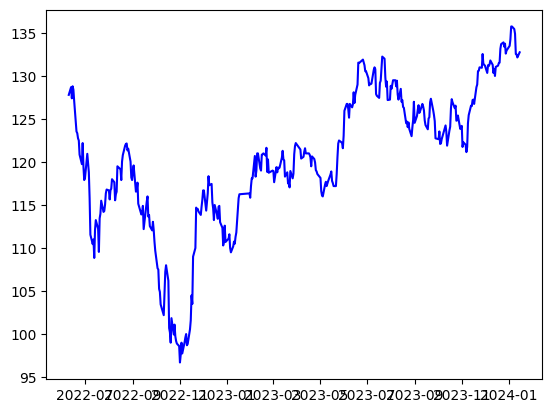

In [14]:
import matplotlib.pyplot as plt

# 繪製測試集與預測結果的對比圖
df_time = df.index[-len(y_test):]  # df_time 是與 y_test 相對應的時間軸
plt.plot(df_time, y_test, color='blue', label='price')
plt.plot(df_time, pre, color='purple', label='predict')
plt.legend()
plt.show()